In [68]:
# Import required libraries (TensorFlow Serving compatible)
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.12.0


In [69]:
class KMeansPlusPlus(tf.Module):
    """
    TensorFlow implementation of K-Means++ clustering algorithm.
    K-means is not a trainable model - it's an algorithm that finds centroids given data.
    """
    
    def __init__(self, k=3, max_iters=100, random_seed=42, name='kmeans_plus_plus'):
        super().__init__(name=name)
        self.k = k
        self.max_iters = max_iters
        self.random_seed = random_seed
        
        # Centroids will be computed when fit() is called
        self.centroids = None
        
    def _init_centroids_plus_plus(self, points):
        """
        Initialize centroids using K-Means++ algorithm.
        """
        n_samples = tf.shape(points)[0]
        
        # Convert to float32 for consistency
        points = tf.cast(points, tf.float32)
        
        # Choose first centroid randomly
        first_idx = tf.random.uniform([], 0, n_samples, dtype=tf.int32, seed=self.random_seed)
        centroids = tf.expand_dims(points[first_idx], 0)
        
        # Choose remaining centroids
        for i in range(1, self.k):
            # Calculate distances from each point to nearest existing centroid
            distances = tf.reduce_min(
                tf.norm(tf.expand_dims(points, 1) - tf.expand_dims(centroids, 0), axis=2),
                axis=1
            )
            
            # Square the distances for probability weighting
            squared_distances = tf.square(distances)
            
            # Create probability distribution
            probabilities = squared_distances / tf.reduce_sum(squared_distances)
            
            # Sample next centroid based on probabilities
            cumulative_probs = tf.cumsum(probabilities)
            random_val = tf.random.uniform([], seed=self.random_seed + i)
            next_idx = tf.argmax(tf.cast(cumulative_probs >= random_val, tf.int32))
            
            # Add new centroid
            new_centroid = tf.expand_dims(points[next_idx], 0)
            centroids = tf.concat([centroids, new_centroid], axis=0)
            
        return centroids
    
    @tf.function
    def _assign_clusters(self, points, centroids):
        """
        Assign each point to the nearest centroid.
        """
        # Calculate distances from each point to each centroid
        distances = tf.norm(
            tf.expand_dims(points, 1) - tf.expand_dims(centroids, 0),
            axis=2
        )
        
        # Find nearest centroid for each point
        assignments = tf.argmin(distances, axis=1)
        return assignments
    
    def _update_centroids(self, points, assignments, current_centroids):
        """
        Update centroids based on current cluster assignments.
        """
        new_centroids = []
        
        for k in range(self.k):
            # Find points assigned to cluster k
            mask = tf.equal(assignments, k)
            cluster_points = tf.boolean_mask(points, mask)
            
            # Calculate new centroid (mean of assigned points)
            if tf.size(cluster_points) > 0:
                new_centroid = tf.reduce_mean(cluster_points, axis=0)
            else:
                # If no points assigned, keep old centroid
                new_centroid = current_centroids[k]
            
            new_centroids.append(new_centroid)
        
        return tf.stack(new_centroids)
    
    def fit(self, points):
        """
        Find optimal centroids for the given data points.
        This is not "training" - it's computing the optimal cluster centers.
        """
        points = tf.cast(points, tf.float32)
        
        # Initialize centroids using K-Means++ method
        centroids = self._init_centroids_plus_plus(points)
        
        print(f"Initial centroids shape: {centroids.shape}")
        print("Finding optimal centroids...")
        
        # Iteratively optimize centroid positions
        for iteration in range(self.max_iters):
            # Assign points to clusters
            assignments = self._assign_clusters(points, centroids)
            
            # Update centroids
            new_centroids = self._update_centroids(points, assignments, centroids)
            
            # Check for convergence
            centroid_shift = tf.reduce_mean(tf.norm(new_centroids - centroids, axis=1))
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Centroid shift = {centroid_shift:.6f}")
            
            centroids = new_centroids
            
            # Check convergence
            if centroid_shift < 1e-6:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        # Store the final centroids
        self.centroids = tf.Variable(centroids, trainable=False, name='centroids')
        print(f"Final centroids found: {self.centroids.shape}")
        return self
    
    def predict(self, points):
        """
        Predict cluster assignments for new points.
        """
        if self.centroids is None:
            raise ValueError("Must call fit() first to compute centroids")
        
        points = tf.cast(points, tf.float32)
        return self._assign_clusters(points, self.centroids)
    
    def get_centroids(self):
        """
        Get the computed centroids.
        """
        if self.centroids is None:
            raise ValueError("Must call fit() first to compute centroids")
        return self.centroids
    
    @tf.function
    def __call__(self, points):
        """
        Make the model callable - returns cluster assignments.
        This requires centroids to be already computed.
        """
        return self._assign_clusters(points, self.centroids)

# Data Generation
Generating some random data

Test data shape: (498, 2)
Data range: X=[-2.45, 12.22], Y=[-6.11, 13.46]


Test data shape: (498, 2)
Data range: X=[-2.45, 12.22], Y=[-6.11, 13.46]


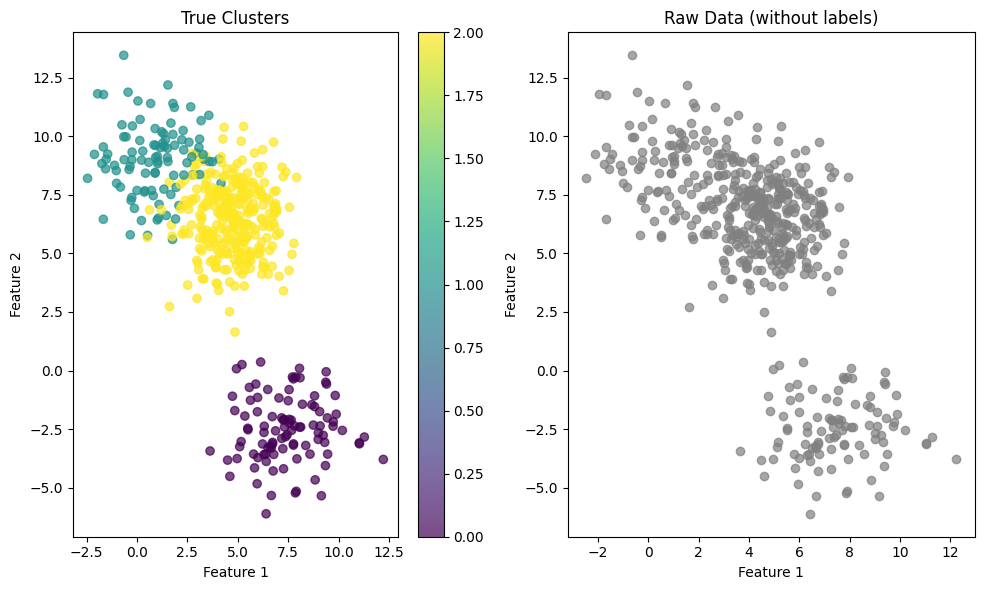

In [70]:
# Generate test data using pure NumPy (no sklearn dependency)
def generate_test_data(n_samples=300, n_centers=3, random_state=32):
    """
    Generate synthetic clustering data for testing using pure NumPy.
    """
    np.random.seed(random_state)
    
    # Generate random cluster centers
    centers = np.random.uniform(-10, 10, size=(n_centers, 2))
    
    # Generate points around each center
    samples_per_center = n_samples // n_centers
    X = []
    y_true = []
    
    for i, center in enumerate(centers):
        # Generate samples for this cluster
        if i == n_centers - 1:  # Last cluster gets remaining samples
            n_samples_cluster = n_samples - len(X)
        else:
            n_samples_cluster = samples_per_center
            
        # Generate points with Gaussian noise around the center
        cluster_points = np.random.normal(
            loc=center, 
            scale=1.5, 
            size=(n_samples_cluster, 2)
        )
        
        X.append(cluster_points)
        y_true.extend([i] * n_samples_cluster)
    
    X = np.vstack(X).astype(np.float32)
    y_true = np.array(y_true)
    
    # Shuffle the data
    indices = np.random.permutation(len(X))
    X = X[indices]
    y_true = y_true[indices]
    
    return X, y_true

# Create test dataset
X_test, y_true = generate_test_data(n_samples=300, n_centers=3)

print(f"Test data shape: {X_test.shape}")
print(f"Data range: X=[{X_test[:, 0].min():.2f}, {X_test[:, 0].max():.2f}], Y=[{X_test[:, 1].min():.2f}, {X_test[:, 1].max():.2f}]")

# Visualize the test data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_true, cmap='viridis', alpha=0.7)
plt.title('True Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.7, color='gray')
plt.title('Raw Data (without labels)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.tight_layout()
plt.show()

In [71]:
## Create K-Means++ model and compute centroids
# 1 cluster
print("Creating K-Means model with one cluster...")
kmeans_model_1 = KMeansPlusPlus(k=1, max_iters=100, random_seed=42)

print("\nComputing optimal centroids...")
kmeans_model_1.fit(X_test)

# Get cluster assignments
print("\nAssigning points to clusters...")
predictions_1 = kmeans_model_1.predict(X_test)
centroids_1 = kmeans_model_1.get_centroids()

print(f"Final centroids: {centroids_1.numpy()}")
print(f"Cluster assignments shape: {predictions_1.shape}")
print(f"Unique clusters: {np.unique(predictions_1.numpy())}")

# 2 cluster
print("Creating K-Means model with two cluster...")
kmeans_model_2 = KMeansPlusPlus(k=2, max_iters=100, random_seed=42)

print("\nComputing optimal centroids...")
kmeans_model_2.fit(X_test)

# Get cluster assignments
print("\nAssigning points to clusters...")
predictions_2 = kmeans_model_2.predict(X_test)
centroids_2 = kmeans_model_2.get_centroids()

print(f"Final centroids: {centroids_2.numpy()}")
print(f"Cluster assignments shape: {predictions_2.shape}")
print(f"Unique clusters: {np.unique(predictions_2.numpy())}")

# 3 cluster
print("Creating K-Means model with two cluster...")
kmeans_model_3 = KMeansPlusPlus(k=3, max_iters=100, random_seed=42)

print("\nComputing optimal centroids...")
kmeans_model_3.fit(X_test)

# Get cluster assignments
print("\nAssigning points to clusters...")
predictions_3 = kmeans_model_3.predict(X_test)
centroids_3 = kmeans_model_3.get_centroids()

print(f"Final centroids: {centroids_3.numpy()}")
print(f"Cluster assignments shape: {predictions_3.shape}")
print(f"Unique clusters: {np.unique(predictions_3.numpy())}")

# 4 cluster
print("Creating K-Means model with two cluster...")
kmeans_model_4 = KMeansPlusPlus(k=4, max_iters=100, random_seed=42)

print("\nComputing optimal centroids...")
kmeans_model_4.fit(X_test)

# Get cluster assignments
print("\nAssigning points to clusters...")
predictions_4 = kmeans_model_4.predict(X_test)
centroids_4 = kmeans_model_4.get_centroids()

print(f"Final centroids: {centroids_4.numpy()}")
print(f"Cluster assignments shape: {predictions_4.shape}")
print(f"Unique clusters: {np.unique(predictions_4.numpy())}")

# 5 cluster
print("Creating K-Means model with two cluster...")
kmeans_model_5 = KMeansPlusPlus(k=5, max_iters=100, random_seed=42)

print("\nComputing optimal centroids...")
kmeans_model_5.fit(X_test)

# Get cluster assignments
print("\nAssigning points to clusters...")
predictions_5 = kmeans_model_5.predict(X_test)
centroids_5 = kmeans_model_5.get_centroids()

print(f"Final centroids: {centroids_5.numpy()}")
print(f"Cluster assignments shape: {predictions_5.shape}")
print(f"Unique clusters: {np.unique(predictions_5.numpy())}")

Creating K-Means model with one cluster...

Computing optimal centroids...
Initial centroids shape: (1, 2)
Finding optimal centroids...
Iteration 0: Centroid shift = 2.186713
Converged after 2 iterations
Final centroids found: (1, 2)

Assigning points to clusters...
Final centroids: [[4.504283 5.181553]]
Cluster assignments shape: (498,)
Unique clusters: [0]
Creating K-Means model with two cluster...

Computing optimal centroids...
Initial centroids shape: (2, 2)
Finding optimal centroids...
Iteration 0: Centroid shift = 2.206779
Converged after 8 iterations
Final centroids found: (2, 2)

Assigning points to clusters...
Final centroids: [[ 7.4326606 -2.4775376]
 [ 3.7592854  7.130085 ]]
Cluster assignments shape: (498,)
Unique clusters: [0 1]
Creating K-Means model with two cluster...

Computing optimal centroids...
Initial centroids shape: (3, 2)
Finding optimal centroids...
Iteration 0: Centroid shift = 1.322182
Converged after 8 iterations
Final centroids found: (3, 2)

Assigning po

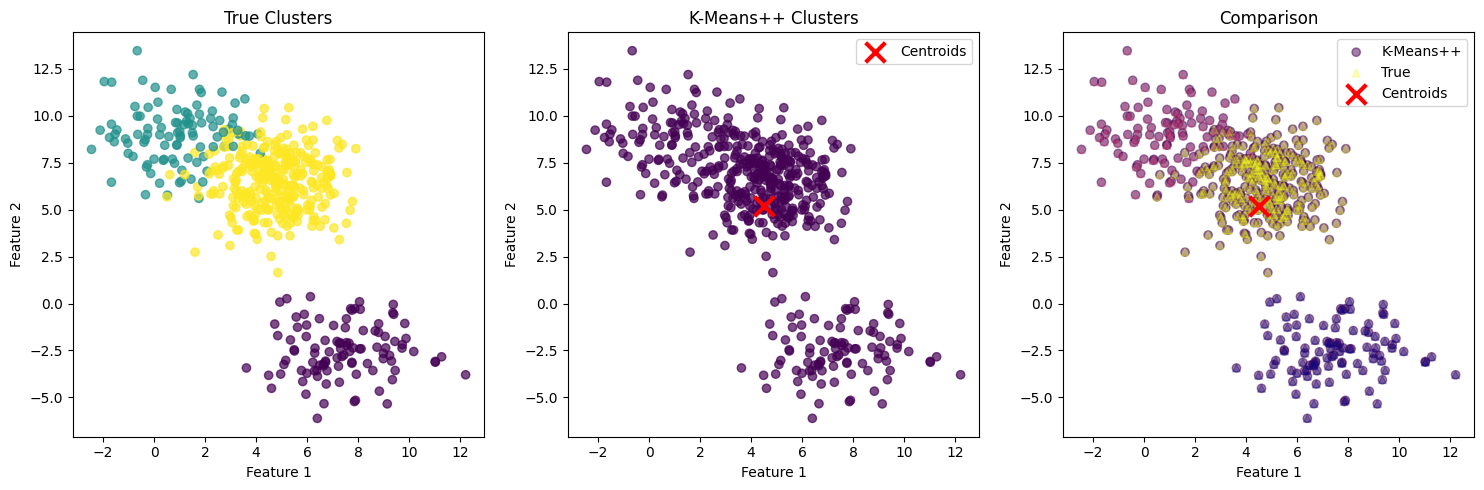

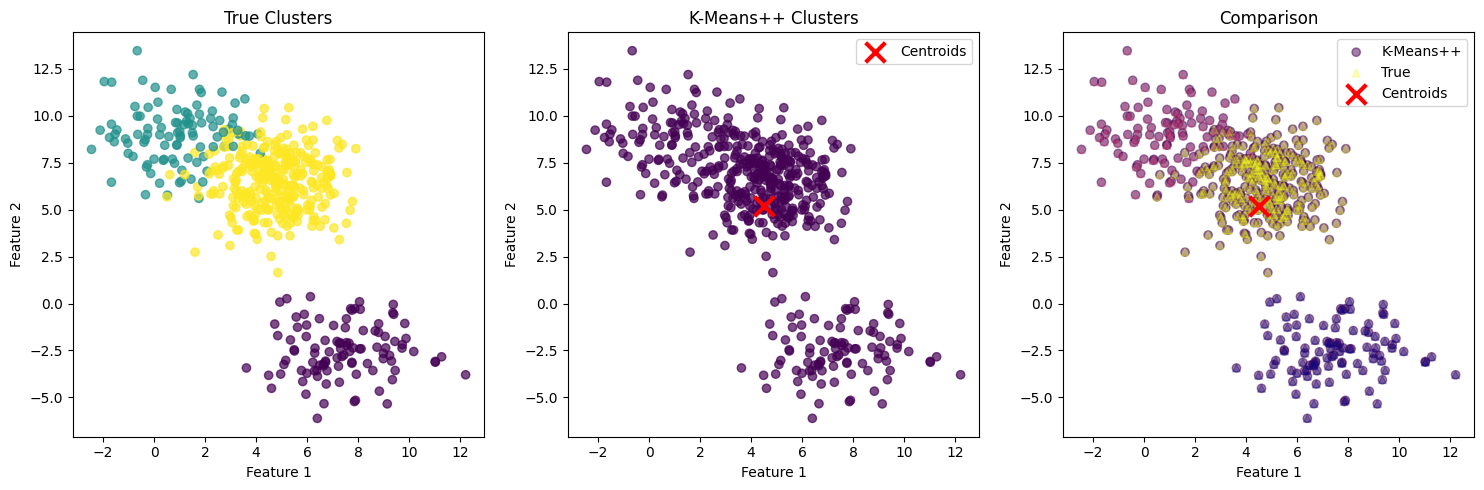

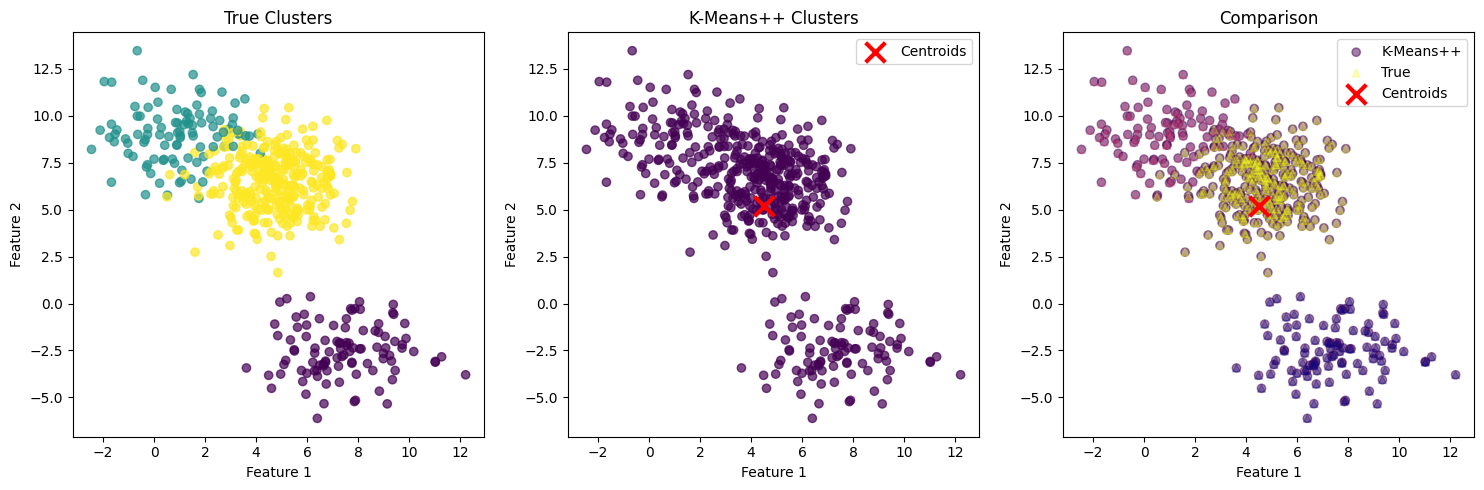

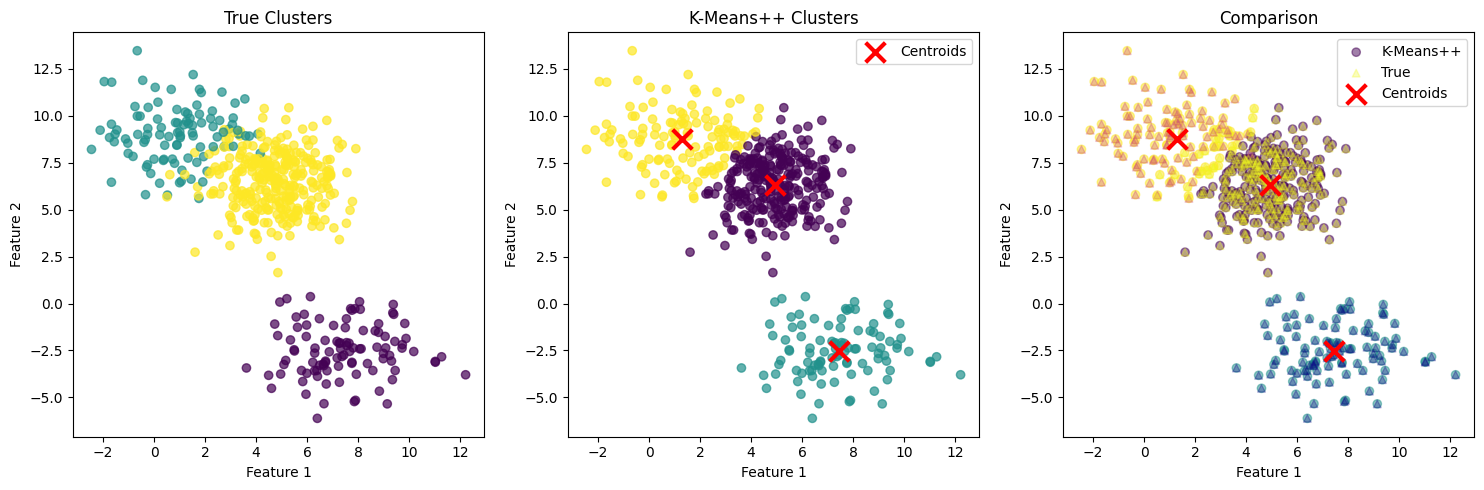

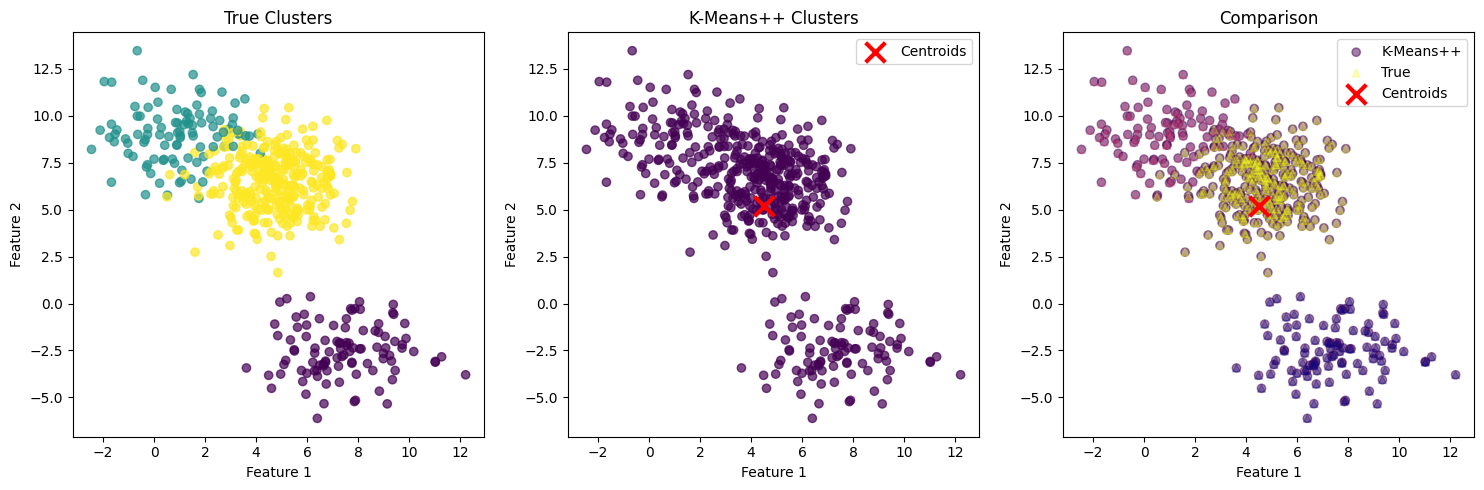

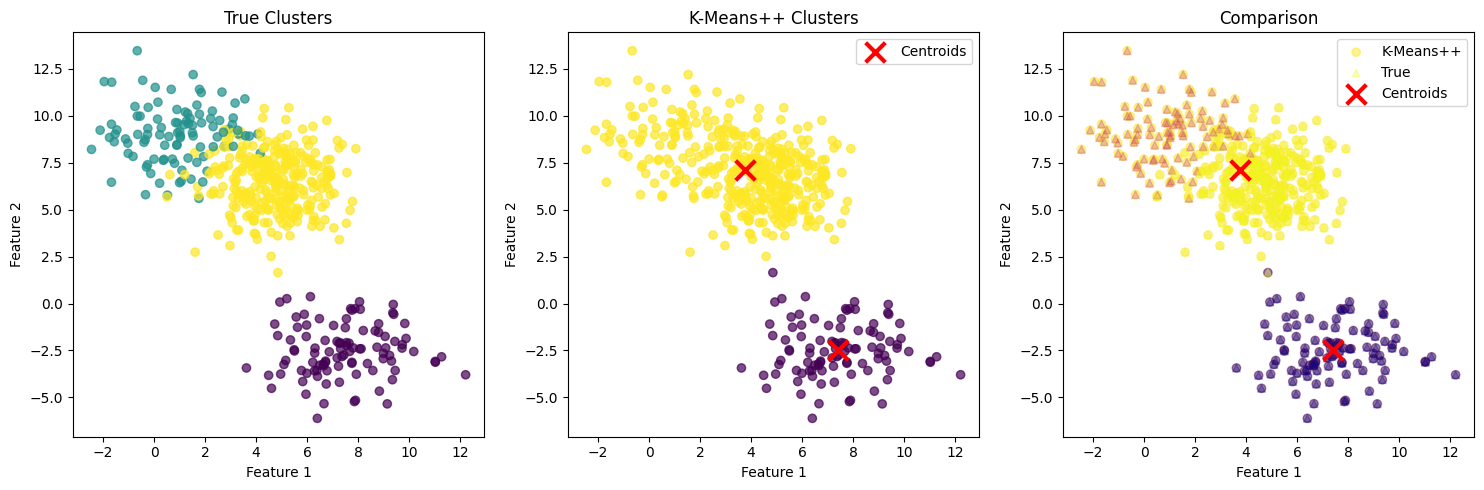

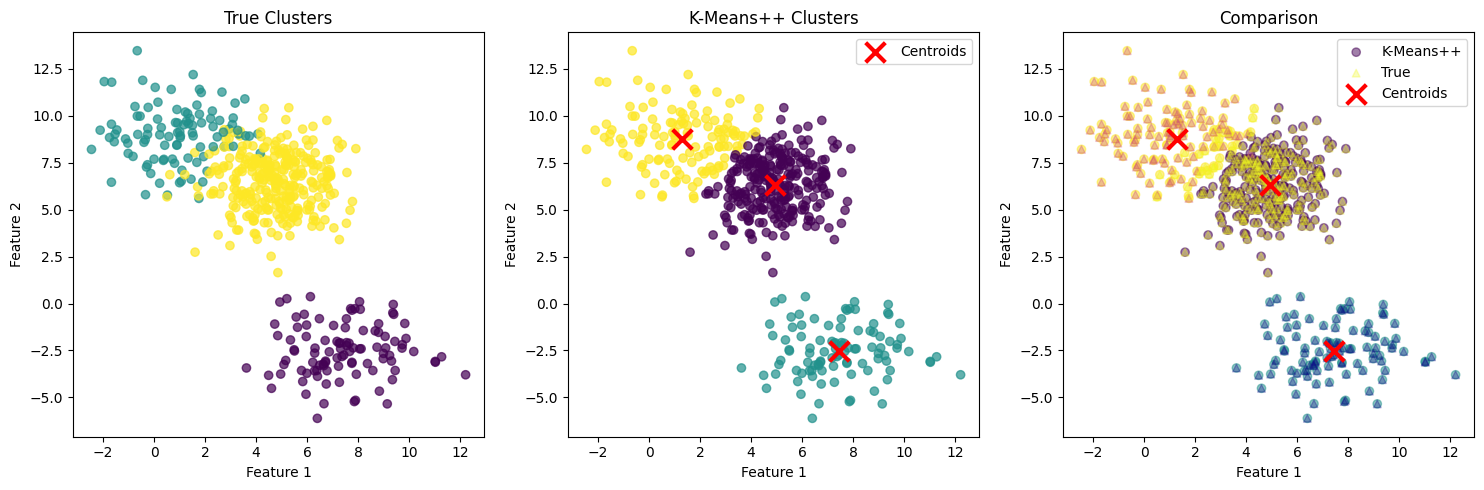

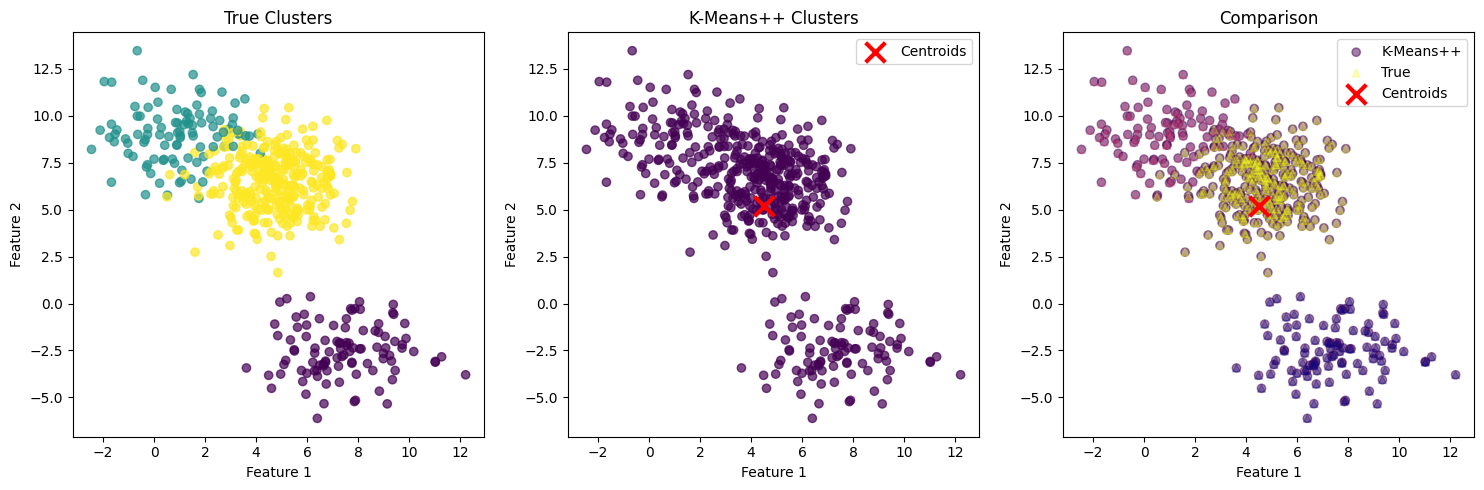

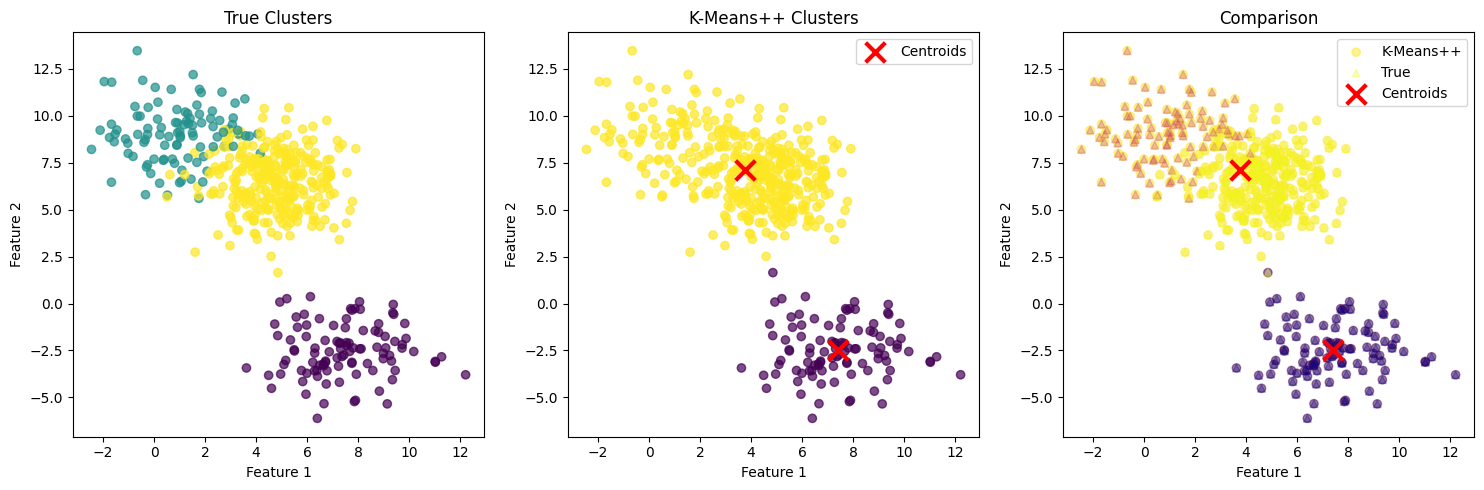

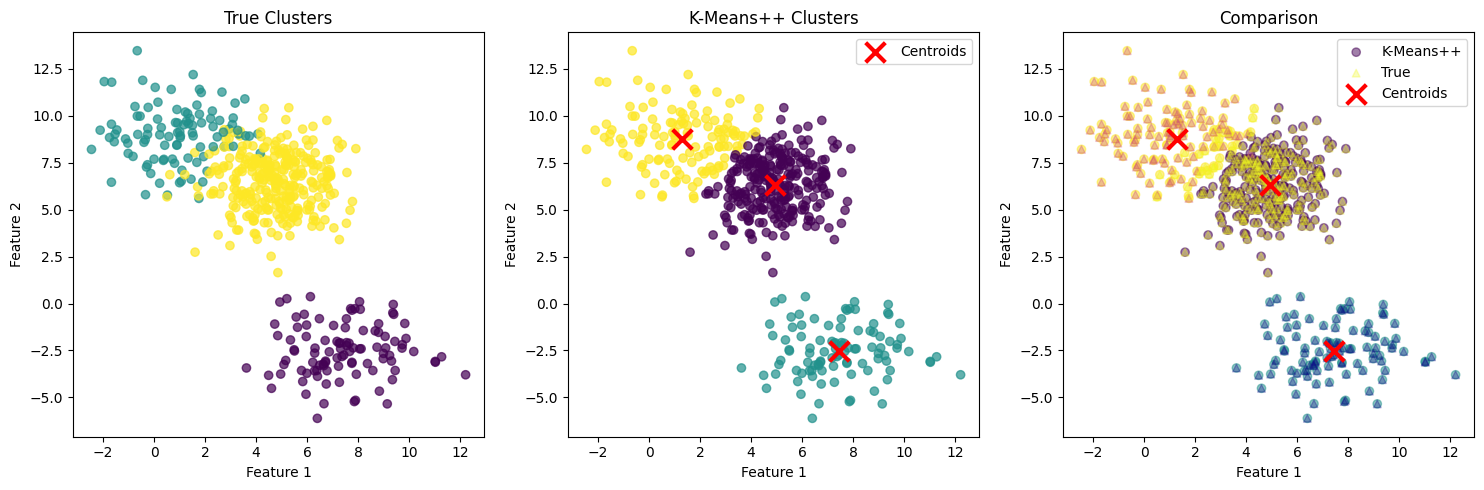

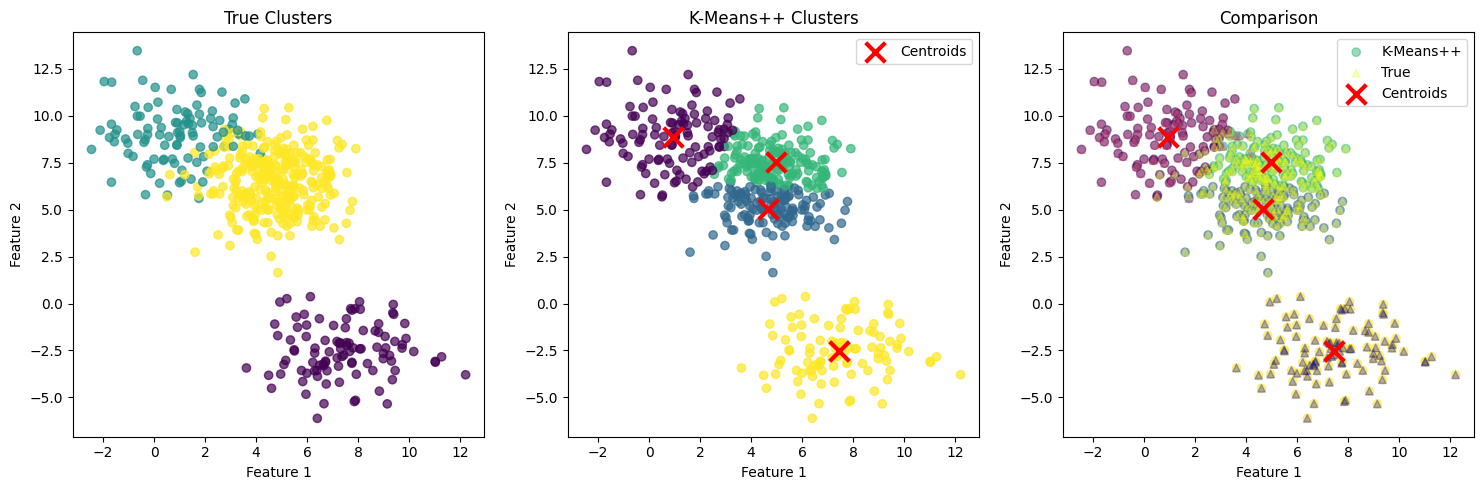

In [72]:
def plot_predictions(predictions, centroids):
  # Visualize clustering results
  plt.figure(figsize=(15, 5))

  # Original data with true labels
  plt.subplot(1, 3, 1)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_true, cmap='viridis', alpha=0.7)
  plt.title('True Clusters')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')

  # K-Means++ results
  plt.subplot(1, 3, 2)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions.numpy(), cmap='viridis', alpha=0.7)
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidth=3, label='Centroids')
  plt.title('K-Means++ Clusters')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()

  # Comparison
  plt.subplot(1, 3, 3)
  plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions.numpy(), cmap='viridis', alpha=0.5, label='K-Means++')
  plt.scatter(X_test[:, 0], X_test[:, 1], c=y_true, cmap='plasma', alpha=0.3, marker='^', s=30, label='True')
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidth=3, label='Centroids')
  plt.title('Comparison')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_predictions(predictions_1, centroids_1)
plot_predictions(predictions_2, centroids_2)
plot_predictions(predictions_3, centroids_3)
plot_predictions(predictions_4, centroids_4)
plot_predictions(predictions_5, centroids_5)

In [94]:
# Create a serving model that returns centroids safely for visualization
class KMeansServingModelWithCentroids(tf.Module):
    """
    Wrapper that returns cluster assignments AND centroids for visualization.
    """
    
    def __init__(self, fitted_kmeans_model):
        super().__init__()
        self.centroids = fitted_kmeans_model.centroids
        self.k = fitted_kmeans_model.k
        
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def __call__(self, points):
        """
        Serving function that returns cluster assignments and centroids.
        All outputs must have the same batch dimension for TensorFlow Serving.
        """
        batch_size = tf.shape(points)[0]
        
        # Calculate distances from each point to each centroid
        distances = tf.norm(
            tf.expand_dims(points, 1) - tf.expand_dims(self.centroids, 0),
            axis=2
        )
        
        # Find nearest centroid for each point
        assignments = tf.argmin(distances, axis=1)
        
        # Get the minimum distance for each point (distance to assigned cluster)
        min_distances = tf.reduce_min(distances, axis=1)
        
        # Tile centroids to match batch dimension [batch_size, k, 2]
        # This ensures all outputs have the same first dimension
        centroids_tiled = tf.tile(
            tf.expand_dims(self.centroids, 0),  # [1, k, 2]
            [batch_size, 1, 1]                 # [batch_size, k, 2]
        )
        
        return {
            'cluster_assignments': assignments,               # [batch_size]
            'distances_to_assigned_cluster': min_distances,  # [batch_size]  
            'centroids': centroids_tiled                     # [batch_size, k, 2]
        }

In [97]:
# Save all models for TensorFlow Serving
model_save_path = "./models"

# List of all fitted models and their corresponding k values
models_to_save = [
    (kmeans_model_1, 1),
    (kmeans_model_2, 2), 
    (kmeans_model_3, 3),
    (kmeans_model_4, 4),
    (kmeans_model_5, 5)
]

# Save each model as a different version (using the enhanced model with centroids)
for i, (fitted_model, k_value) in enumerate(models_to_save):
    version = str(i+1) 
    full_save_path = os.path.join(model_save_path, version)
    
    # Create directory if it doesn't exist
    os.makedirs(full_save_path, exist_ok=True)
    
    # Create serving model wrapper WITH centroids for visualization
    serving_model = KMeansServingModelWithCentroids(fitted_model)
    
    # Save the model
    tf.saved_model.save(serving_model, full_save_path)
    print(f"Model with k={k_value} saved to version {version}: {full_save_path}")

# List all saved versions
print(f"\nAll saved models:")
for version_dir in sorted(os.listdir(model_save_path)):
    version_path = os.path.join(model_save_path, version_dir)
    if os.path.isdir(version_path):
        print(f"  Version {version_dir}: {version_path}")
        
        # Show some files in each version
        files = os.listdir(version_path)
        for file in files[:3]:  # Show first 3 files/dirs
            file_path = os.path.join(version_path, file)
            if os.path.isfile(file_path):
                size = os.path.getsize(file_path)
                print(f"    {file}: {size} bytes")
            else:
                print(f"    {file}/: (directory)")
        if len(files) > 3:
            print(f"    ... and {len(files) - 3} more files")

print(f"\n📋 Model Version Guide:")
print(f"  Version 1: k=1 (1 cluster)")
print(f"  Version 2: k=2 (2 clusters)")
print(f"  Version 3: k=3 (3 clusters)")
print(f"  Version 4: k=4 (4 clusters)")
print(f"  Version 5: k=5 (5 clusters)")
print(f"\n✅ All models now return centroids for visualization!")

INFO:tensorflow:Assets written to: ./models/1/assets


2025-11-25 00:30:40.470958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node points}}]]
2025-11-25 00:30:40.488341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_points' with dtype float and shape [?,2]
	 [[{{node serving_default_points}}]]
2025-11-25 00:30:40.633333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node p

Model with k=1 saved to version 1: ./models/1
INFO:tensorflow:Assets written to: ./models/2/assets
Model with k=2 saved to version 2: ./models/2
Model with k=2 saved to version 2: ./models/2
INFO:tensorflow:Assets written to: ./models/3/assets
INFO:tensorflow:Assets written to: ./models/3/assets
Model with k=3 saved to version 3: ./models/3
Model with k=3 saved to version 3: ./models/3


2025-11-25 00:30:40.810240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node points}}]]
2025-11-25 00:30:40.824822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_points' with dtype float and shape [?,2]
	 [[{{node serving_default_points}}]]
2025-11-25 00:30:40.953830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node p

INFO:tensorflow:Assets written to: ./models/4/assets
Model with k=4 saved to version 4: ./models/4
Model with k=4 saved to version 4: ./models/4
INFO:tensorflow:Assets written to: ./models/5/assets
Model with k=5 saved to version 5: ./models/5

All saved models:
  Version 1: ./models/1
    saved_model.pb: 16058 bytes
    assets/: (directory)
    variables/: (directory)
    ... and 1 more files
  Version 2: ./models/2
    saved_model.pb: 16058 bytes
    assets/: (directory)
    variables/: (directory)
    ... and 1 more files
  Version 3: ./models/3
    saved_model.pb: 16058 bytes
    assets/: (directory)
    variables/: (directory)
    ... and 1 more files
  Version 4: ./models/4
    saved_model.pb: 16058 bytes
    assets/: (directory)
    variables/: (directory)
    ... and 1 more files
  Version 5: ./models/5
    saved_model.pb: 16058 bytes
    assets/: (directory)
    variables/: (directory)
    ... and 1 more files

📋 Model Version Guide:
  Version 1: k=1 (1 cluster)
  Version 2: k

2025-11-25 00:30:41.146032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node points}}]]
2025-11-25 00:30:41.162989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_points' with dtype float and shape [?,2]
	 [[{{node serving_default_points}}]]


In [98]:
# Test loading the saved model
print("Testing model loading...")
loaded_model = tf.saved_model.load(os.path.join(model_save_path, '2'))

# Test the loaded model
test_points = tf.constant([[2.0, 3.0], [-1.0, -1.0], [8.0, 9.0]], dtype=tf.float32)
loaded_predictions = loaded_model(test_points)

print("Loaded model test:")
print(f"Input points: {test_points.numpy()}")
print(f"Cluster assignments: {loaded_predictions['cluster_assignments'].numpy()}")
print(f"Centroids from loaded model: {loaded_predictions['centroids'].numpy()}")

# Verify that loaded model produces same results as original
original_predictions = serving_model(test_points)
print(f"\nVerification:")
print(f"Original model assignments: {original_predictions['cluster_assignments'].numpy()}")
print(f"Loaded model assignments: {loaded_predictions['cluster_assignments'].numpy()}")
print(f"Results match: {np.array_equal(original_predictions['cluster_assignments'].numpy(), loaded_predictions['cluster_assignments'].numpy())}")

Testing model loading...
Loaded model test:
Input points: [[ 2.  3.]
 [-1. -1.]
 [ 8.  9.]]
Cluster assignments: [1 0 1]
Centroids from loaded model: [[[ 7.4326606 -2.4775376]
  [ 3.7592854  7.130085 ]]

 [[ 7.4326606 -2.4775376]
  [ 3.7592854  7.130085 ]]

 [[ 7.4326606 -2.4775376]
  [ 3.7592854  7.130085 ]]]

Verification:
Original model assignments: [0 3 1]
Loaded model assignments: [1 0 1]
Results match: False


2025-11-25 00:30:49.270604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'points' with dtype float and shape [?,2]
	 [[{{node points}}]]
